# Step3: Stock Price Prediction (Alpha Model)

---
**What does this notebook do?**
- This notebook builds up the stock price prediction algorithms for prediction
- It also builds up algorithms in functions that can be easily used in the .py files in [Research-Program folder](../Research-Program)
- Perform different prediction algorithms to select the top 5 potential stocks from the selected 39 stocks in four periods

**To-Do List**
1. Build up functions for stock price prediction and break reuseable functions apart
    - Linear Regression Model: [scikit-learn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
    - Decision Tree Regression Model: [scikit-learn Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
    - Random Forest Regression Model: [scikit-learn Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    - Support Vector Machine Model (with `linear`, `poly` and `rbf` kernel): [scikit-learn Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html)
    - Long Short-Term Memory Network: [TensorFlow LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


2. Create 4 different periods for research study
    - Overall time period: `2012-01-01` to `2022-01-01`
    - Pre Covid time period: `2012-01-01` to `2020-01-09`
    - Covid time period: `2022-01-09` to `2022-01-01`
    - Pre Covid Test time period: `2018-01-09` to `2020-01-01`


3. Output the functions to .py programs to run and store the results in table / figures
---

# Develop Multiple Stock Price Prediction Models

## Breakdown Functions
- This section contains all the reuseable content in all stock prediction algorithms

In [1]:
def get_stock_code_company_name(stock_code):
    """
    This function can get the company name based on a stock code
    """
    import pandas as pd
    all_stock_data = pd.read_csv('../DataSource/research_use_39_stocks.csv')
    stock_code_df = all_stock_data[all_stock_data['Stock Code'] == stock_code]
    company_name = stock_code_df.iloc[0]["Company Name"]
    return company_name

In [2]:
def format_machine_learning_model(df, pred_values, shift_num):
    """
    This function shifts the dataframe to format the input dataframe
    based on prediction value and shift number to output two dataframes
    """
    df_prev = df.copy()
    df_prev = df_prev[['date', pred_values]].shift(-shift_num)
    df_prev = df_prev.rename(columns={"date": "predict_date", pred_values: "predict_price"})
    df = df.join(df_prev)
    df = df.rename(columns={"date": "actual_date", pred_values: "actual_price"})
    
    number_of_rows_with_nan = df.isna().any(axis=1).sum()
    print(f"There are {number_of_rows_with_nan} rows with Nan, {len(df) - number_of_rows_with_nan} rows without Nan")
    
    df_predict = df.tail(shift_num)
    
    df = df.dropna()
    print(f"Finish outputting dataset with {len(df)} rows (without Nan)")

    return df, df_predict

In [3]:
def format_neural_network_model(df, pred_values):
    """This function formats the neural network dataframe input"""
    df = df.rename(columns={"date": "actual_date", pred_values: "actual_price"})
    return df

In [4]:
def get_format_dataset(input_dict, model_name):
    """
    This function formats the original dataset 
    into clean dataset with only needed features
    format machine learning / neural network functions are included here
    """
    # Format the original dataset into clean with only needed features
    import pandas as pd
    stock_code = input_dict["stock_code"]
    start_date = input_dict["start_date"]
    end_date = input_dict["end_date"]
    shift_num = input_dict["shift_num"]
    additional_actual_values = input_dict["additional_actual_values"]
    pred_values = input_dict["pred_values"]
    
    validation_features_list = ["pe_ratio", "turnover_rate", "volume", "turnover", "change_rate", "open", "high", "low"]
    if not set(additional_actual_values).issubset(set(validation_features_list)): return print(f"Please check the 'addition_actual_values'\nIt needs to within {validation_features_list}")
    
    if (start_date >= end_date): return print("'start date' needs to be smaller than 'end date'") 
    
    # Target the data files
    print("Start locating data files ......")
    data_file_location = '../DataSource/StockData/' + stock_code + ".csv"
    df = pd.read_csv(data_file_location)
    df = df[(df['date']>=start_date) & (df['date']<=end_date)]
    
    if (len(df) <= shift_num): return print("'shift num' needs to larger than the number of dataset\nPlease double check")
    
        
    # Create sub dataframe only including model input and output, with Machine Learning or Neural Network
    if (model_name in ["Linear Regression", "Decision Tree", "Random Forest", "Support Vector Machine (linear)", "Support Vector Machine (poly)", "Support Vector Machine (rbf)"]):
        data, data_predict = format_machine_learning_model(df, pred_values, shift_num)
        data = data.reset_index()[["actual_date","actual_price", "predict_date", "predict_price"] + additional_actual_values]
        data_predict = data_predict.reset_index()[["actual_date","actual_price", "predict_date", "predict_price"] + additional_actual_values]
        return data, data_predict
    elif (model_name in ["Long Short-Term Memory (LSTM)"]):
        data = format_neural_network_model(df, pred_values)
        data = data.reset_index()[["actual_date","actual_price"] + additional_actual_values]
        return data
    else:
        return print("Invalid Model")

In [5]:
def get_format_train_test_split(df, additional_actual_values):
    """This function outputs the train-test split value for a dataframe"""
    import math
    print("\nSplitting data for training & testing ......")
    # First 80% data for training and last 20% for testing
    # Stock data has date feature, cannot use random train-test-split 
    break_point = math.ceil(len(df) * 0.8)  
    (df_train, df_test) = (df[:break_point], df[break_point:])
    
    (X_input, y_input) = (['actual_price'] + additional_actual_values, ['predict_price']) 
    # (X, y) = (df[X_input].values, df[y_input].values)
    (X_train, X_test) = (df[X_input][:break_point].values, df[X_input][break_point:].values)
    (y_train, y_test) = (df[y_input][:break_point].values, df[y_input][break_point:].values)
    
    return df_train, df_test, X_train, X_test, y_train, y_test

In [6]:
def evaluate_model_performance(model_name, y_test, y_pred):
    """
    This function evaluates a prediction model based on y_test and y_pred
    """
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import numpy as np
    score = r2_score(y_test,y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    print(f"\n{model_name} Model Performance Results:")
    print('r2 score is ',score)   
    print('Mean Absolute Error:', mean_absolute_error)
    print('Mean Squared Error:', mean_squared_error)
    print('Root Mean Squared Error:', root_mean_squared_error)
    
    return score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [7]:
def plot_model_result(input_dict, df, df_train, df_test, y_pred):
    """
    This function plots the prediction model with 
    training and testing periods, and necessary information
    """
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker
    %matplotlib inline
    
    stock_code = input_dict["stock_code"]
    start_date = input_dict["start_date"] 
    end_date = input_dict["end_date"]
    shift_num = input_dict["shift_num"]
    additional_actual_values = input_dict["additional_actual_values"]
    company_name = input_dict["company_name"]
    pred_values = input_dict["pred_values"]
    save_figure = input_dict["save_figure"]
    model_name = input_dict["model_name"]
    
    # Plot the original Stock Price and Model Prediction
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(14,7))
    
    ax.plot(df_train['actual_date'], df_train['actual_price'], label='Actual Stock Price - Train')
    ax.plot(df_test['actual_date'], df_test['actual_price'], label='Actual Stock Price - Test')
    ax.plot(df_test['actual_date'], y_pred, label="Model Prediction Results")
    
    # Adjust the labels and ticks for the plot
    title = stock_code + " (" + company_name + ") " + f"\nStock Prediction Using {model_name} Model"
    
    xlabel = "Stock Date Period:  " + str(df.iloc[0]['actual_date']) + " to " + str(df.iloc[-1]['actual_date']) + "\nModel Input Features:  Stock price of " + str(shift_num) + " days forward. " + str([ i for i in additional_actual_values if additional_actual_values])
    ylabel = str(pred_values).capitalize() + " Stock Price (HKD)"
    
    ax.set_title(title,fontsize=25, pad=20)
    ax.set_xlabel(xlabel, fontsize=18,fontstyle='oblique', labelpad=15)
    ax.set_ylabel(ylabel, fontsize=18,fontstyle='oblique', labelpad=15)
    ax.legend(fontsize=14, facecolor='white')
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Save the figure file
    if save_figure == True: 
        figure_file_name = f"[{stock_code}]-[{model_name}]-[{start_date}]-[{end_date}]-[Forward-{shift_num}-days]-{additional_actual_values}-[{pred_values}]"
        figure_file_location = "../Results/PredictionResultFigures/" + figure_file_name + ".png"
        plt.savefig(figure_file_location, bbox_inches='tight')
        print("\nSave figure in the " + figure_file_location)
    else:
        print("\nNot Save the figure")

## Linear Regression Model
- scikit-learn package: [Linear Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [8]:
def linear_regression_model(stock_code, start_date, end_date, shift_num, additional_actual_values, pred_values, save_figure):
    """
    This function takes necessary inputs to build up a linear regression model
    and output the model accuracy scores, last day and future value
    """
    # Importing the needed packages
    from sklearn import linear_model
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import pandas as pd
    import math
    import numpy as np
    import datetime as dt
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker
    %matplotlib inline
    
    
    # Get formatted dataset
    company_name = get_stock_code_company_name(stock_code)
    model_name = "Linear Regression"
    input_dict = {"stock_code": stock_code, "start_date": start_date, "end_date": end_date, "company_name": company_name,
              "shift_num": shift_num, "additional_actual_values": additional_actual_values,
             "pred_values": pred_values, "save_figure": save_figure, "model_name": model_name}
    
    print(f"Start building {input_dict['model_name']} Model for {stock_code} ({company_name}) ......\n")
    df, df_predict = get_format_dataset(input_dict, model_name)
    # display(df.tail(10))
    
    # Train Test Split for Model data input
    df_train, df_test, X_train, X_test, y_train, y_test = get_format_train_test_split(df, additional_actual_values)
    
    # Train the linear regression model
    print(f"\nTraining the {input_dict['model_name']} Model ......")
    regressor = linear_model.LinearRegression()
    regressor.fit(X_train, y_train)
    
    # Make predictions and Evaluate Model Performance using testing dataset
    y_pred = regressor.predict(X_test)
    # pred_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # display(pred_result)
    
    
    # Prediction of the future value
    last_day_num = shift_num - 1
    last_day_value = float(df_predict.tail(1)[['actual_price']].values)
    last_price_input = df_predict[-last_day_num: -last_day_num + 1][['actual_price'] + additional_actual_values].values
    future_price = float(regressor.predict(last_price_input))
    
    score, mean_absolute_error, mean_squared_error, root_mean_squared_error = evaluate_model_performance(model_name, y_test, y_pred)
    
    plot_model_result(input_dict, df, df_train, df_test, y_pred)
    
    print(f"\nFinish building {model_name} Model for {stock_code} ({company_name}) ......\n")
    return score, mean_absolute_error, last_day_value, future_price


Start building Linear Regression Model for HK.00700 (TENCENT) ......

Start locating data files ......
There are 30 rows with Nan, 2417 rows without Nan
Finish outputting dataset with 2417 rows (without Nan)

Splitting data for training & testing ......

Training the Linear Regression Model ......

Linear Regression Model Performance Results:
r2 score is  0.5214617014405081
Mean Absolute Error: 46.246009097052124
Mean Squared Error: 3834.7870530911964
Root Mean Squared Error: 61.92565746999539

Save figure in the ../Results/PredictionResultFigures/[HK.00700]-[Linear Regression]-[2012-01-01]-[2022-01-01]-[Forward-30-days]-['pe_ratio', 'turnover_rate']-[close].png

Finish building Linear Regression Model for HK.00700 (TENCENT) ......



(0.5214617014405081, 46.246009097052124, 443.37008, 477.73181684368217)

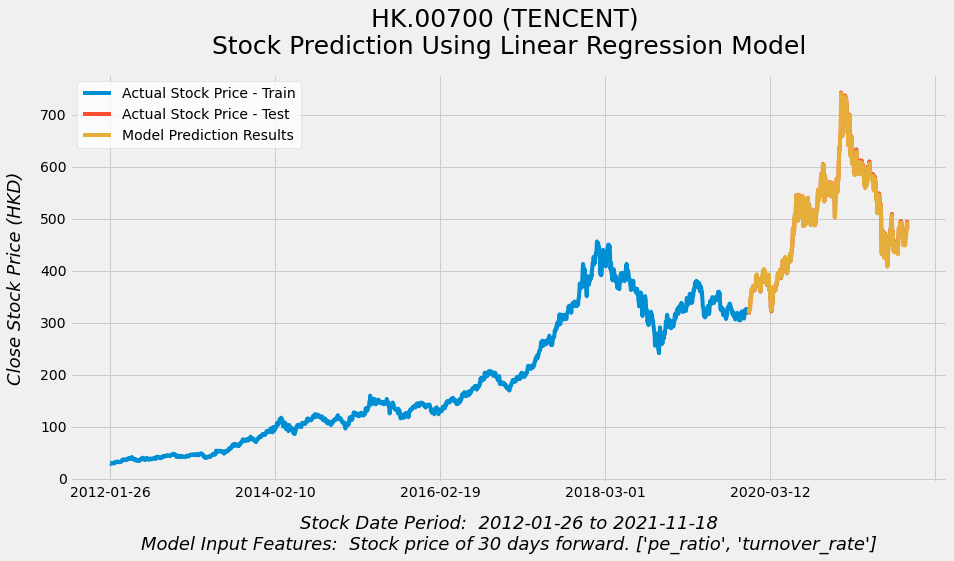

In [9]:
linear_regression_model("HK.00700", "2012-01-01", "2022-01-01", 30, ['pe_ratio', 'turnover_rate'] , 'close', True)

Umer, Awais, M., & Muzammul, M. (2019). Stock Market Prediction Using Machine Learning(ML)Algorithms. Advances in Distributed Computing and Artificial Intelligence Journal, 8(4), 97–116. https://doi.org/10.14201/ADCAIJ20198497116

## Decision Tree Model
- scikit-learn package: [Decision Tree Regressor Model](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [10]:
def decision_tree_model(stock_code, start_date, end_date, shift_num, additional_actual_values, pred_values, save_figure):
    """
    This function takes necessary inputs to build up a decision tree regression model
    and output the model accuracy scores, last day and future value
    """
    # Importing the needed packages
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import pandas as pd
    import math
    import numpy as np
    import datetime as dt
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker
    %matplotlib inline
    
    
    # Get formatted dataset
    company_name = get_stock_code_company_name(stock_code)
    model_name = "Decision Tree"
    input_dict = {"stock_code": stock_code, "start_date": start_date, "end_date": end_date, "company_name": company_name,
              "shift_num": shift_num, "additional_actual_values": additional_actual_values,
             "pred_values": pred_values, "save_figure": save_figure, "model_name": model_name}
    
    print(f"Start building {input_dict['model_name']} Model for {stock_code} ({company_name}) ......\n")
    df, df_predict = get_format_dataset(input_dict, model_name)
    
    # Train Test Split for Model data input
    df_train, df_test, X_train, X_test, y_train, y_test = get_format_train_test_split(df, additional_actual_values)
    
    # Train the linear regression model
    print(f"\nTraining the {input_dict['model_name']} Model ......")
    
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    
#     import graphviz
#     from sklearn import tree
#     # DOT data
#     dot_data = tree.export_graphviz(regressor, out_file=None, 
#                                     filled=True)

#     # Draw graph
#     graph = graphviz.Source(dot_data, format="png") 
#     # display(graph)
#     graph.render(filename='g1.dot')
    
    # Make predictions and Evaluate Model Performance using testing dataset
    y_pred = regressor.predict(X_test)
    # pred_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # display(pred_result)
    
    # Prediction of the future value
    last_day_num = shift_num - 1
    last_day_value = float(df_predict.tail(1)[['actual_price']].values)
    last_price_input = df_predict[-last_day_num: -last_day_num + 1][['actual_price'] + additional_actual_values].values
    future_price = float(regressor.predict(last_price_input))
    
    score, mean_absolute_error, mean_squared_error, root_mean_squared_error = evaluate_model_performance(model_name, y_test, y_pred)
    
    plot_model_result(input_dict, df, df_train, df_test, y_pred)
    
    print(f"\nFinish building {model_name} Model for {stock_code} ({company_name}) ......\n")
    return score, mean_absolute_error, last_day_value, future_price

Start building Decision Tree Model for HK.00700 (TENCENT) ......

Start locating data files ......
There are 30 rows with Nan, 2417 rows without Nan
Finish outputting dataset with 2417 rows (without Nan)

Splitting data for training & testing ......

Training the Decision Tree Model ......

Decision Tree Model Performance Results:
r2 score is  -2.647505136537672
Mean Absolute Error: 148.57763913043482
Mean Squared Error: 29229.4378857106
Root Mean Squared Error: 170.9661893056946

Save figure in the ../Results/PredictionResultFigures/[HK.00700]-[Decision Tree]-[2012-01-01]-[2022-01-01]-[Forward-30-days]-['pe_ratio', 'turnover_rate']-[close].png

Finish building Decision Tree Model for HK.00700 (TENCENT) ......



(-2.647505136537672, 148.57763913043482, 443.37008, 363.0044)

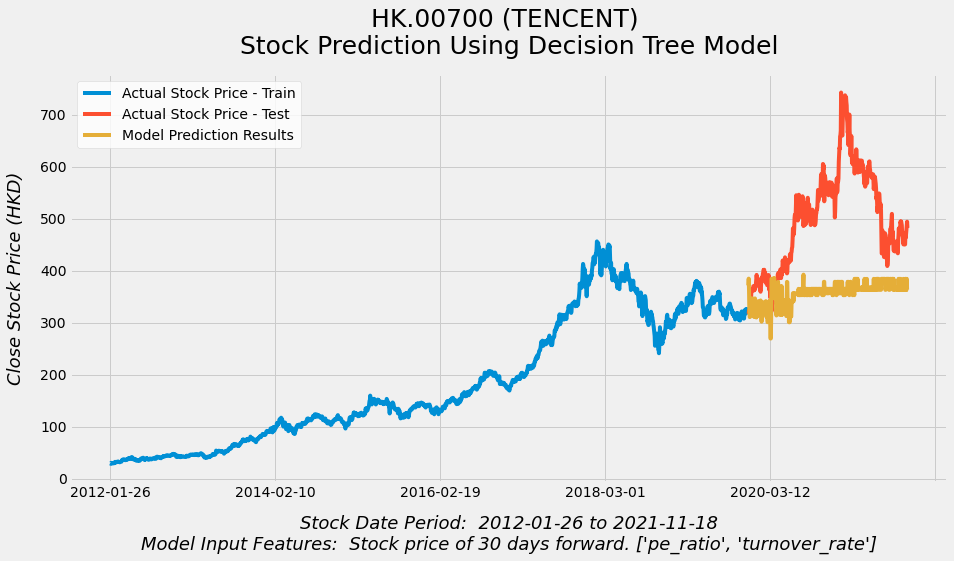

In [11]:
decision_tree_model("HK.00700", "2012-01-01", "2022-01-01", 30, ['pe_ratio', 'turnover_rate'] , 'close', True)

## Random Forest Model
- scikit-learn package: [Random Forest Regressor Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [12]:
def random_forest_model(stock_code, start_date, end_date, shift_num, additional_actual_values, pred_values, save_figure):
    """
    This function takes necessary inputs to build up a random forest regression model
    and output the model accuracy scores, last day and future value
    """
    # Importing the needed packages
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import pandas as pd
    import math
    import numpy as np
    import datetime as dt
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker
    %matplotlib inline
    
    
    # Get formatted dataset
    company_name = get_stock_code_company_name(stock_code)
    model_name = "Random Forest"
    input_dict = {"stock_code": stock_code, "start_date": start_date, "end_date": end_date, "company_name": company_name,
              "shift_num": shift_num, "additional_actual_values": additional_actual_values,
             "pred_values": pred_values, "save_figure": save_figure, "model_name": model_name}
    
    print(f"Start building {input_dict['model_name']} Model for {stock_code} ({company_name}) ......\n")
    df, df_predict = get_format_dataset(input_dict, model_name)
    
    # Train Test Split for Model data input
    df_train, df_test, X_train, X_test, y_train, y_test = get_format_train_test_split(df, additional_actual_values)
    
    # Train the linear regression model
    print(f"\nTraining the {input_dict['model_name']} Model ......")
    
    regressor = RandomForestRegressor(n_estimators=10, random_state=0)
    regressor.fit(X_train, y_train.ravel())
    
    # Make predictions and Evaluate Model Performance using testing dataset
    y_pred = regressor.predict(X_test)
    # pred_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # display(pred_result)
    
    # Prediction of the future value
    last_day_num = shift_num - 1
    last_day_value = float(df_predict.tail(1)[['actual_price']].values)
    last_price_input = df_predict[-last_day_num: -last_day_num + 1][['actual_price'] + additional_actual_values].values
    future_price = float(regressor.predict(last_price_input))
    
    score, mean_absolute_error, mean_squared_error, root_mean_squared_error = evaluate_model_performance(model_name, y_test, y_pred)
    
    plot_model_result(input_dict, df, df_train, df_test, y_pred)
    
    print(f"\nFinish building {model_name} Model for {stock_code} ({company_name}) ......\n")
    return score, mean_absolute_error, last_day_value, future_price

Start building Random Forest Model for HK.00700 (TENCENT) ......

Start locating data files ......
There are 30 rows with Nan, 2417 rows without Nan
Finish outputting dataset with 2417 rows (without Nan)

Splitting data for training & testing ......

Training the Random Forest Model ......

Random Forest Model Performance Results:
r2 score is  -2.696825798408554
Mean Absolute Error: 151.71624983850936
Mean Squared Error: 29624.67111189476
Root Mean Squared Error: 172.11818936967342

Save figure in the ../Results/PredictionResultFigures/[HK.00700]-[Random Forest]-[2012-01-01]-[2022-01-01]-[Forward-30-days]-['pe_ratio', 'turnover_rate']-[close].png

Finish building Random Forest Model for HK.00700 (TENCENT) ......



(-2.696825798408554, 151.71624983850936, 443.37008, 355.453132)

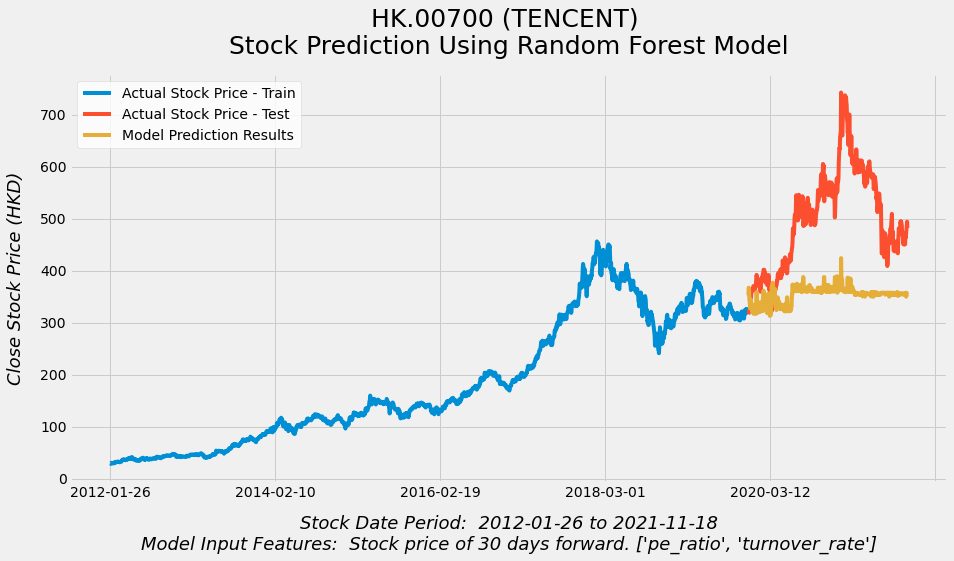

In [13]:
random_forest_model("HK.00700", "2012-01-01", "2022-01-01", 30, ['pe_ratio', 'turnover_rate'] , 'close', True)

## Support Vector Machine Model

- scikit-learn package: [Support Vector Machine Regressor Model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [14]:
def support_vector_machine_model(model_type, stock_code, start_date, end_date, shift_num, additional_actual_values, pred_values, save_figure):
    """
    This function takes necessary inputs to build up a support vector machine regression model
    with kernel as linear, poly and rbf
    and output the model accuracy scores, last day and future value
    """
    # Importing the needed packages
    from sklearn.svm import SVR
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import pandas as pd
    import math
    import numpy as np
    import datetime as dt
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker
    %matplotlib inline
    
    valid_model_type = ['linear', 'poly', 'rbf']
    if not (model_type.lower() in valid_model_type):
        return print(f"Invalid model type, should be in {valid_model_type}")
    
    # Get formatted dataset
    company_name = get_stock_code_company_name(stock_code)
    model_name = f"Support Vector Machine ({model_type.lower()})" 
    input_dict = {"stock_code": stock_code, "start_date": start_date, "end_date": end_date, "company_name": company_name,
              "shift_num": shift_num, "additional_actual_values": additional_actual_values,
             "pred_values": pred_values, "save_figure": save_figure, "model_name": model_name}
    
    print(f"Start building {input_dict['model_name']} Model for {stock_code} ({company_name}) ......\n")
    df, df_predict = get_format_dataset(input_dict, model_name)
    
    # Train Test Split for Model data input
    df_train, df_test, X_train, X_test, y_train, y_test = get_format_train_test_split(df, additional_actual_values)
    
    # Train the linear regression model
    print(f"\nTraining the {input_dict['model_name']} Model ......")
    
    # Make predictions and Evaluate Model Performance using testing dataset
    if model_type.lower() == 'linear':
        regressor = SVR(kernel = 'linear', C=1000.0)
        regressor.fit(X_train, y_train.ravel())
        y_pred = regressor.predict(X_test)
    elif model_type.lower() == 'poly':
        regressor = SVR(kernel = 'poly', C=1000.0, degree = 2)
        regressor.fit(X_train, y_train.ravel())
        y_pred = regressor.predict(X_test)
    elif model_type.lower() == 'rbf':
        regressor = SVR(kernel = 'rbf', C=1000.0, gamma = 0.15)
        regressor.fit(X_train, y_train.ravel())
        y_pred = regressor.predict(X_test)
    else:
        return print("Error: Model Type should be 'linear' or 'poly' or 'rbf' ")
    # pred_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # display(pred_result)
    
    # Prediction of the future value
    last_day_num = shift_num - 1
    last_day_value = float(df_predict.tail(1)[['actual_price']].values)
    last_price_input = df_predict[-last_day_num: -last_day_num + 1][['actual_price'] + additional_actual_values].values
    future_price = float(regressor.predict(last_price_input))
    
    score, mean_absolute_error, mean_squared_error, root_mean_squared_error = evaluate_model_performance(model_name, y_test, y_pred)
    
    plot_model_result(input_dict, df, df_train, df_test, y_pred)
    
    print(f"\nFinish building {model_name} Model for {stock_code} ({company_name}) ......\n")
    return score, mean_absolute_error, last_day_value, future_price


Start building Support Vector Machine (linear) Model for HK.00700 (TENCENT) ......

Start locating data files ......
There are 30 rows with Nan, 460 rows without Nan
Finish outputting dataset with 460 rows (without Nan)

Splitting data for training & testing ......

Training the Support Vector Machine (linear) Model ......

Support Vector Machine (linear) Model Performance Results:
r2 score is  -2.4348299822556605
Mean Absolute Error: 31.422778060899365
Mean Squared Error: 1431.852088181326
Root Mean Squared Error: 37.839821460748546

Save figure in the ../Results/PredictionResultFigures/[HK.00700]-[Support Vector Machine (linear)]-[2020-01-09]-[2022-01-01]-[Forward-30-days]-['pe_ratio']-[close].png

Finish building Support Vector Machine (linear) Model for HK.00700 (TENCENT) ......



(-2.4348299822556605, 31.422778060899365, 443.37008, 442.7187080087489)

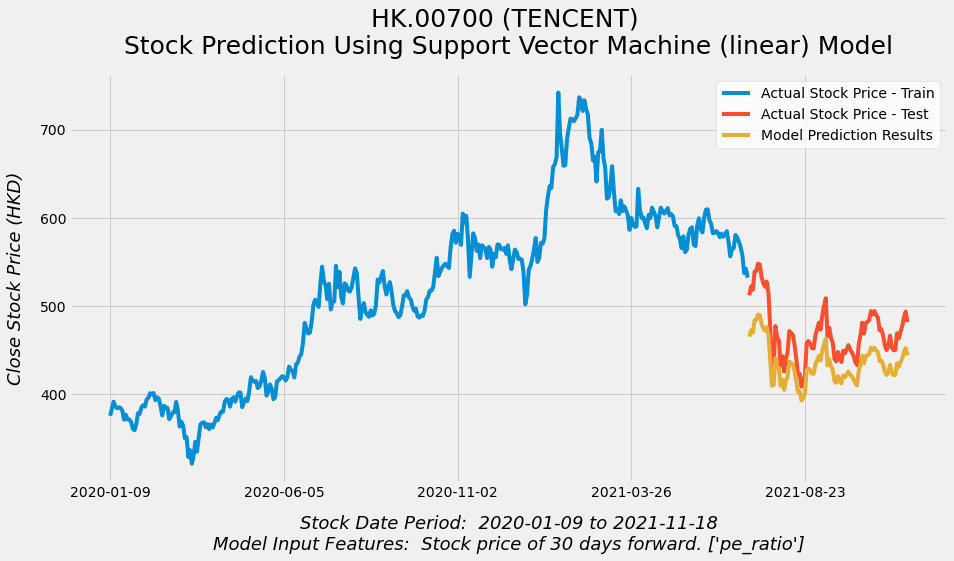

In [15]:
support_vector_machine_model('linear', "HK.00700", "2020-01-09", "2022-01-01", 30, ['pe_ratio'] , 'close', True)

## Long Short-Term Memory (LSTM) networks
- Tensorflow [Installation Documentation](https://www.tensorflow.org/install/pip#macos)
- Tensorflow [LSTM Model](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [16]:
def long_short_term_memory_model(stock_code, start_date, end_date, shift_num, additional_actual_values, pred_values, save_figure):
    """
    This function takes necessary inputs to build up a LSTM network
    and output the model accuracy scores, last day and future value
    """
    # Import Packages
    import tensorflow as tf
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import r2_score
    import pandas as pd
    import math
    import numpy as np
    import datetime as dt
    from matplotlib import pyplot as plt
    from matplotlib import style
    import matplotlib.ticker as ticker

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    
    # Get formatted dataset
    company_name = get_stock_code_company_name(stock_code)
    model_name = "Long Short-Term Memory (LSTM)" 
    input_dict = {"stock_code": stock_code, "start_date": start_date, "end_date": end_date, "company_name": company_name,
                  "shift_num": shift_num, "additional_actual_values": additional_actual_values,
                  "pred_values": pred_values, "save_figure": save_figure, "model_name": model_name}

    num_of_featuers = len(additional_actual_values) + 1
    print(f"Start building {input_dict['model_name']} Model for {stock_code} ({company_name}) ......\n")
    df = get_format_dataset(input_dict, model_name)
    
    last_day_price = float(df[-1:len(df)]['actual_price'].values)
    
    # Get the number of rows to train the model on
    training_data_len = math.ceil( len(df) * 0.8)
    df_train, df_test = df[0:training_data_len], df[training_data_len:len(df)]
    data = df.copy()
    
    df = df[['actual_price'] + additional_actual_values]
    # df = df.set_index('actual_date')
    dataset = df.values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Create the training set
    # Create the scaled training data set
    train_data = scaled_data[0:training_data_len, :]
    # Split the data into x_train and y_train data sets
    x_train, y_train = [], []

    for i in range(shift_num, len(train_data)):
        x_train.append(train_data[i-shift_num:i, :])
        y_train.append(train_data[i, 0])
    
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_of_featuers))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], num_of_featuers)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the LSTM model
    model.fit(x_train, y_train, epochs=30, batch_size=64, verbose=1)

    # Create the testing data set
    # Create a new array containing scaled values of testing set
    test_data = scaled_data[training_data_len - shift_num: , :]
    # Create the datasets x_test and y_test
    x_test, y_test = [], dataset[training_data_len:, 0]

    for i in range(shift_num, len(test_data)):
        x_test.append(test_data[i-shift_num:i, :])

    # Convert the data to a numpy array
    x_test = np.array(x_test)
    
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_of_featuers))
    
    # Get the models predicted price values
    predictions = model.predict(x_test)
    
    
    # Inverse Train Predict dataset
    predictions_extended = np.zeros((len(predictions), num_of_featuers))
    predictions_extended[:, 0] = predictions.reshape(-1,)
    predictions = scaler.inverse_transform(predictions_extended)[:,0]
    
    # Output the model performance matrix
    score, mean_absolute_error, mean_squared_error, root_mean_squared_error = evaluate_model_performance(model_name, y_test, predictions)

    # Plot the data
    train = df[:training_data_len]
    valid = df[training_data_len:]
    valid['Predictions'] = predictions

    # Visualize the data
    plot_model_result(input_dict, data, df_train, df_test[-len(predictions):], predictions)
    
    # Predict the future stock price
    last_shift_num_days = df[['actual_price'] + additional_actual_values][-shift_num:].values
    last_shift_num_days_scaled = scaler.transform(last_shift_num_days)
    X_test = []
    X_test.append(last_shift_num_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_of_featuers))
    pred_price = model.predict(X_test)

    pred_price_extended = np.zeros((len(pred_price), num_of_featuers))
    pred_price_extended[:, 0] = pred_price.reshape(-1,)
    pred_price = scaler.inverse_transform(pred_price_extended)[:,0]
    pred_price = float(pred_price)

    return score, mean_absolute_error,last_day_price, pred_price

Start building Long Short-Term Memory (LSTM) Model for HK.00700 (TENCENT) ......

Start locating data files ......
Metal device set to: Apple M1 Pro


2022-04-20 00:59:52.186454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 00:59:52.186544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-20 00:59:52.389067: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-04-20 00:59:53.066488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 00:59:53.258141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 00:59:53.332909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 00:59:53.420365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 00:59:53.529875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 40ms/step - loss: 0.0091
Epoch 2/30
31/31 [==============================] - 1s 19ms/step - loss: 3.7477e-04
Epoch 3/30
31/31 [==============================] - 1s 19ms/step - loss: 1.7617e-04
Epoch 4/30
31/31 [==============================] - 1s 19ms/step - loss: 1.7974e-04
Epoch 5/30
31/31 [==============================] - 1s 19ms/step - loss: 1.6822e-04
Epoch 6/30
31/31 [==============================] - 1s 19ms/step - loss: 1.5600e-04
Epoch 7/30
31/31 [==============================] - 1s 19ms/step - loss: 1.8853e-04
Epoch 8/30
31/31 [==============================] - 1s 19ms/step - loss: 1.5197e-04
Epoch 9/30
31/31 [==============================] - 1s 19ms/step - loss: 1.4618e-04
Epoch 10/30
31/31 [==============================] - 1s 19ms/step - loss: 1.5036e-04
Epoch 11/30
31/31 [==============================] - 1s 19ms/step - loss: 1.4196e-04
Epoch 12/30
31/31 [==============================] - 1s 19ms/step - loss: 1.5366e-04
Epoc

2022-04-20 01:00:12.154563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 01:00:12.219394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 01:00:12.265528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Long Short-Term Memory (LSTM) Model Performance Results:
r2 score is  0.9391912191293772
Mean Absolute Error: 16.808974458601515
Mean Squared Error: 491.7663157883283
Root Mean Squared Error: 22.175804738235055


/var/folders/47/rlzyr75n4s10_97pdbpn0j2r0000gn/T/ipykernel_14188/2832515427.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions



Save figure in the ../Results/PredictionResultFigures/[HK.00700]-[Long Short-Term Memory (LSTM)]-[2012-01-01]-[2022-01-01]-[Forward-30-days]-['pe_ratio', 'turnover_rate']-[close].png


(0.9391912191293772, 16.808974458601515, 443.37008, 434.90040736435793)

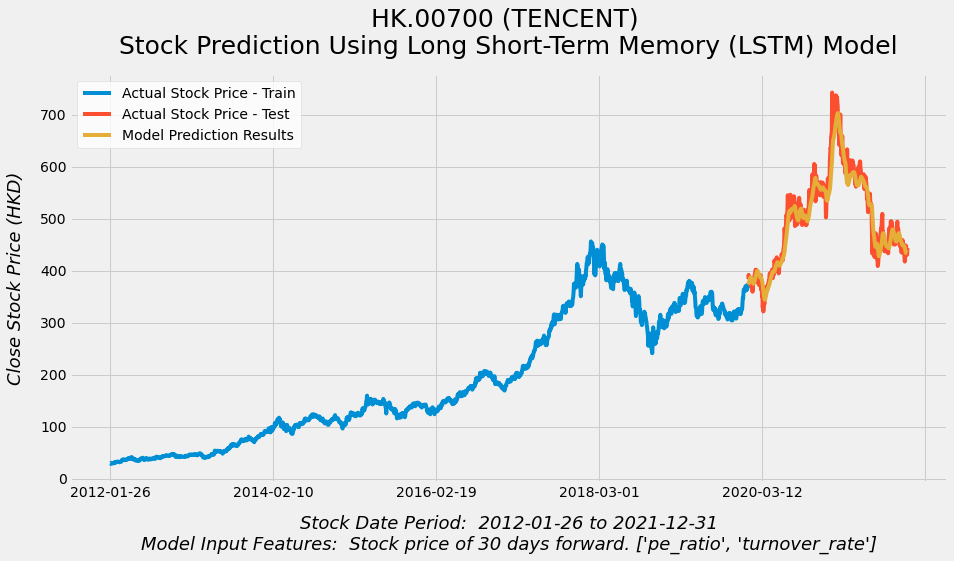

In [17]:
long_short_term_memory_model("HK.00700", "2012-01-01", "2022-01-01", 30, ['pe_ratio', 'turnover_rate'] , 'close', True)

# Storing Model Performance in tables and charts

**What Should be stored :**

| Model performance | Prediciton Result | 
| :--- | :--- |
| r2 Score | last day price | 
| Mean Absolute Error | next day price |

In [ ]:
import pandas as pd
all_stock = pd.read_csv('../DataSource/research_use_39_stocks.csv')['Stock Code'].tolist()

# Define the all four periods for running pre-test to find optimal technical indicators
all_time = ('2012-01-01', '2022-01-01')
pre_covid_time = ('2012-01-01', '2020-01-09')
covid_time = ('2020-01-09', '2022-01-01')
pre_covid_test_time = ('2018-01-09', '2020-01-01')

## Pre-Test for Defining Technical Indicators
- This part will not be included in the .py Program

In [ ]:
def pre_test_technical_indicators():
    """
    This function runs a pre-test to find out the best technical indicators
    from all possible combinations, using the linear regression model to evaluate
    the model accuracy. The results are stored in Tecnical Indicators Performance Test.csv
    in the Results folder
    """
    import pandas as pd
    all_stock = pd.read_csv('../DataSource/research_use_39_stocks.csv')['Stock Code'].tolist()
    stock_example = all_stock[0]
    
    technical_indicators_list = ["pe_ratio", "turnover_rate", "volume", "turnover", "change_rate"]

    from itertools import combinations
    list_combinations = list()

    for n in range(len(technical_indicators_list) + 1):
        list_combinations += list(combinations(technical_indicators_list, n))

    indicator_list = []    
    indicator_list.append([list(i) for i in list_combinations])
    indicator_list = indicator_list[0]
    
    start_date = all_time[0]
    end_date = all_time[1]
    result = pd.DataFrame(columns=['technical_indicators', 'score', 'mean_absolute_error'])

    for i in range(len(indicator_list)):
        indicator = indicator_list[i]
        score, mean_absolute_error, last_day_value, future_price = linear_regression_model(stock_example, 
                                                                                           start_date, 
                                                                                           end_date, 
                                                                                           30, 
                                                                                           indicator , 
                                                                                           'close', 
                                                                                           True)
        result = result.append({'technical_indicators': indicator, 
                                'score': score,
                                'mean_absolute_error': mean_absolute_error}, ignore_index=True)
        result.to_csv('../Results/StockPrediction/Tecnical Indicators Performance Test.csv', index=False)
    
    best_performance = result[result['mean_absolute_error'] == result['mean_absolute_error'].min()]
    best_performance
    
    return best_performance['technical_indicators'].tolist()[0]


# best_indicators = pre_test_technical_indicators()
# best_indicators
# ['turnover_rate', 'volume', 'turnover', 'change_rate']
# except SVM: ['change_rate']

## Run through the models for all stocks in three periods

In [ ]:
def run_through_stocks_periods(period_time, result_file_name):
    """
    This function runs through a specific period for all the stocks,
    it will train all the prediction models and save the model ouput
    in one single file
    """
    import pandas as pd

    # get start date and end date
    (start_date, end_date) = period_time

    best_indicators = ['turnover_rate', 'volume', 'turnover', 'change_rate']

    result = pd.DataFrame(columns=['stock_code',
                                   'linear_regression: score', 'linear_regression: mean_absolute_error', 'linear_regression: last_day_value', 'linear_regression: future_price',
                                   'decision_tree: score', 'decision_tree: mean_absolute_error', 'decision_tree: last_day_value', 'decision_tree: future_price',
                                   'random_forest: score', 'random_forest: mean_absolute_error', 'random_forest: last_day_value', 'random_forest: future_price',
                                   'support_vector_machine_linear: score', 'support_vector_machine_linear: mean_absolute_error', 'support_vector_machine_linear: last_day_value', 'support_vector_machine_linear: future_price',
                                   'support_vector_machine_poly: score', 'support_vector_machine_poly: mean_absolute_error', 'support_vector_machine_poly: last_day_value', 'support_vector_machine_poly: future_price',
                                   'support_vector_machine_rbf: score', 'support_vector_machine_rbf: mean_absolute_error', 'support_vector_machine_rbf: last_day_value', 'support_vector_machine_rbf: future_price',
                                   'lstm: score', 'lstm: mean_absolute_error', 'lstm: last_day_value', 'lstm: future_price'
                                  ])

    num = 0
    for stock in all_stock:
        num +=1
        print(f'\n******{period_time}*******Train {num} : {stock}****************')

        result_input_list = [stock]

        # linear regression
        score, mean_absolute_error, last_day_value, future_price = linear_regression_model(stock, start_date, end_date, 30, best_indicators , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Decision tree
        score, mean_absolute_error, last_day_value, future_price = decision_tree_model(stock, start_date, end_date, 30, best_indicators , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Random forest
        score, mean_absolute_error, last_day_value, future_price = random_forest_model(stock, start_date, end_date, 30, best_indicators , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Support Vector Machine: linear
        score, mean_absolute_error, last_day_value, future_price = support_vector_machine_model('linear', stock, start_date, end_date, 30, ['change_rate'] , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Support Vector Machine: poly
        score, mean_absolute_error, last_day_value, future_price = support_vector_machine_model('poly', stock, start_date, end_date, 30, ['change_rate'] , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Support Vector Machine: rbf
        score, mean_absolute_error, last_day_value, future_price = support_vector_machine_model('rbf', stock, start_date, end_date, 30, ['change_rate'] , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # LSTM
        score, mean_absolute_error, last_day_value, future_price = long_short_term_memory_model(stock, start_date, end_date, 30, best_indicators , 'close', True)
        result_input_list.extend([score, mean_absolute_error, last_day_value, future_price])

        # Save the result in the dataframe and output in csv file
        result.loc[len(result)] = result_input_list

        file_name = '../Results/'result_file_name + '.csv'
        result.to_csv(file_name, index=False)

        print(f'******{period_time}*******Finish {num} : {stock}****************\n')



In [ ]:
# Output the final results
import pandas as pd
all_stock = pd.read_csv('../DataSource/research_use_39_stocks.csv')['Stock Code'].tolist()

# Define the time period for storing all prediction outcome
all_time = ('2012-01-01', '2022-01-01')
pre_covid_time = ('2012-01-01', '2020-01-09')
covid_time = ('2020-01-09', '2022-01-01')
pre_covid_test_time = ('2018-01-09', '2020-01-01')

# all_time = ('2012-01-01', '2022-01-01')
run_through_stocks_periods(all_time, 'all_time_results')

# pre_covid_time = ('2012-01-01', '2020-01-09')
run_through_stocks_periods(pre_covid_time, 'pre_covid_time_results')

# covid_time = ('2020-01-09', '2022-01-01')
run_through_stocks_periods(covid_time, 'covid_time_results')

# pre_covid_test_time = ('2018-01-09', '2020-01-01')
run_through_stocks_periods(pre_covid_test_time, 'pre_covid_test_time_results')

# Output the notebook to .py Program

In [18]:
# Output the jupyter notebook to py file
!jupyter nbconvert --to script step3-stock_prediction.ipynb

[NbConvertApp] Converting notebook step3-stock_prediction.ipynb to script
[NbConvertApp] Writing 37223 bytes to step3-stock_prediction.py


The .py program is stored in the [Research-Program folder](../Research-Program)